<a href="https://colab.research.google.com/github/nadya-soto/EcoGrid-Forecast-AI-Driven-Renewable-Energy-Predictions/blob/main/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CE888: Data exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from itertools import product
import os

In [2]:


from sklearn.datasets import load_wine
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, Ridge, LinearRegression, HuberRegressor, ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.validation import check_is_fitted

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score


Importing complete wind and solar energy data for 2010 - 2024 Brighton

In [ ]:
# Directory where the CSV files are located
directory_Brig = 'C:/Users/ethel/Downloads/CE888_proyect/weatherdata_for_students/Brighton'

# List to store the DataFrames of each file
dataframes = []

for file in os.listdir(directory_Brig):     # Iterate over each CSV file in the directory
    if file.endswith('.csv'):
        file_path = os.path.join(directory_Brig, file)
        df = pd.read_csv(file_path)

        if 'datetime' not in df.columns:     # Check if the first row is not 'datetime'
            df = pd.read_csv(file_path, header=1)
        dataframes.append(df)

# Concatenate all DataFrames into one
df = pd.concat(dataframes)

 # Date will be our index. Let's convert it to a datetime type
df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122844 entries, 0 to 923
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   datetime          122844 non-null  datetime64[ns]
 1   temp              122590 non-null  float64       
 2   dew               122568 non-null  float64       
 3   humidity          122575 non-null  float64       
 4   precip            122565 non-null  float64       
 5   precipprob        122558 non-null  float64       
 6   preciptype        11277 non-null   object        
 7   snow              89810 non-null   float64       
 8   snowdepth         89279 non-null   float64       
 9   windspeed         122583 non-null  float64       
 10  winddir           122567 non-null  float64       
 11  sealevelpressure  122319 non-null  float64       
 12  cloudcover        122556 non-null  float64       
 13  solarradiation    122514 non-null  float64       
 14  solaren

In [ ]:
#Lets check the range of dates in our data
print(df['datetime'].min(), df['datetime'].max())

2010-01-01 00:00:00 2024-01-06 11:00:00


In [ ]:
# Let's make the date column the index of the dataframe for easier slicing
df.set_index('datetime', inplace=True)

 Based on this page: https://www.topster.es/calendario/zeitrechner.php?styp=zeit&sdatum=2010-01-01&szeit=00%3A00%3A00&typ=zeit&edatum=2024-01-06&ezeit=11%3A00%3A00&subDazu=%2B&jahredazu=15&wochendazu=0&tagedazu=5&zeitdazu=00%3A00%3A00
            it should be 122843 hours between our range of dates in our data 2010-01-01 00:00:00 2024-01-06 11:00:00
            so we can concluide we have the total hours and we don't have to add any.

In [ ]:
df.isna().sum()   #261 null values for windspeed #364 null values for solarenergy

temp                   254
dew                    276
humidity               269
precip                 279
precipprob             286
preciptype          111567
snow                 33034
snowdepth            33565
windspeed              261
winddir                277
sealevelpressure       525
cloudcover             288
solarradiation         330
solarenergy            364
uvindex                358
dtype: int64

In [ ]:
#display rows which have null values in "solarenergy"
df[df['solarenergy'].isna()].head(5)


,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex
datetime,,,,,,,,,,,,,,,
2010-01-24 03:00:00,3.8,2.5,91.33,0.0,0.0,NaN,0.0,0.0,9.7,345.0,1022.0,100.0,0.0,NaN,0.0
2010-02-05 23:00:00,6.8,5.7,92.55,0.0,0.0,NaN,0.0,0.0,12.4,124.0,1002.7,18.1,0.0,NaN,0.0
2010-03-10 05:00:00,2.4,-0.5,81.29,0.0,0.0,NaN,0.0,0.0,19.1,33.0,1028.2,100.0,0.0,NaN,0.0
2010-03-16 04:00:00,2.1,-0.9,80.92,0.0,0.0,NaN,0.0,0.0,5.5,322.0,1026.4,80.0,0.0,NaN,0.0
2010-04-04 20:00:00,7.7,2.7,70.56,0.0,0.0,NaN,0.0,0.0,11.5,254.0,1018.6,25.5,0.0,NaN,0.0


We have clear periodicity every year. In the plot we see 14 cycles (which correspond to our 14 years of data).

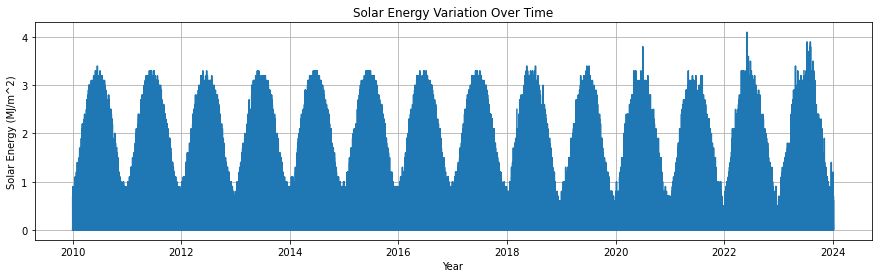

In [ ]:
# Let's plot the solar energy data over the entire time span
plt.figure(figsize=(15,4))
plt.plot(df.index, df['solarenergy'])  # Adjust color if needed
plt.xlabel('Year')
plt.ylabel('Solar Energy (MJ/m^2)')
plt.title('Solar Energy Variation Over Time')
plt.grid(True)  # Adding gridlines for better visualization
plt.show()


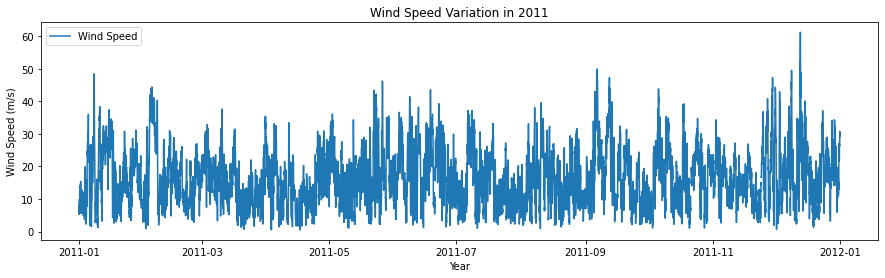

In [ ]:
# Selecting the chunk of data for the year 2011
df_chunk_wind = df.loc['2011-01':'2011-12']

# Creating a figure to plot the wind speed data
plt.figure(figsize=(15,4))

plt.plot(df_chunk_wind.index, df_chunk_wind['windspeed'], label='Wind Speed')

plt.xlabel('Year')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Variation in 2011')

plt.legend()
plt.show()


We are going to Filling null values from the values of the year before

Pero tenemos duplicados entonces me sale un error

In [ ]:
print(df.index.duplicated().any())

True


In [ ]:
df[df.index.duplicated(keep=False)].head(5)

,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex
datetime,,,,,,,,,,,,,,,
2010-10-31 01:00:00,12.4,10.6,88.49,0.000,0.0,NaN,0.0,0.0,15.0,145.0,996.2,34.1,0.0,0.0,0.0
2010-10-31 01:00:00,12.4,10.3,87.33,0.000,0.0,NaN,0.0,0.0,17.9,142.0,996.0,22.4,0.0,0.0,0.0
2011-10-30 01:00:00,14.2,12.3,88.87,0.000,0.0,NaN,0.0,0.0,23.8,227.0,1019.3,100.0,0.0,0.0,0.0
2011-10-30 01:00:00,14.4,12.5,88.08,0.000,0.0,NaN,0.0,0.0,25.3,227.0,1019.1,100.0,0.0,0.0,0.0
2012-10-28 01:00:00,2.6,0.9,88.68,0.112,100.0,rain,0.0,0.0,15.7,339.0,1020.5,6.2,0.0,0.0,0.0


In [ ]:
# Let's keep the first one only for facility we choose this form
df = df[~df.index.duplicated(keep='first')]
len(df) #tenemos 122830 de 122844 que teníamos

122830

In [ ]:
# Now we can reindex -- this is where the original error about duplicates was
df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='H'))
print(len(df))
#df.head(5)
#Ya tenemos de nuevo 122844 valores

122844


In [ ]:
print(df.isna().sum()) #tenemos más missing values

temp                   268
dew                    290
humidity               283
precip                 293
precipprob             300
preciptype          111569
snow                 33044
snowdepth            33575
windspeed              275
winddir                291
sealevelpressure       539
cloudcover             302
solarradiation         344
solarenergy            378
uvindex                372
dtype: int64


Ahora si vamos a Filling null values from the values of the year before (esto es 365 días * 24 horas = 8760 periodos en total)

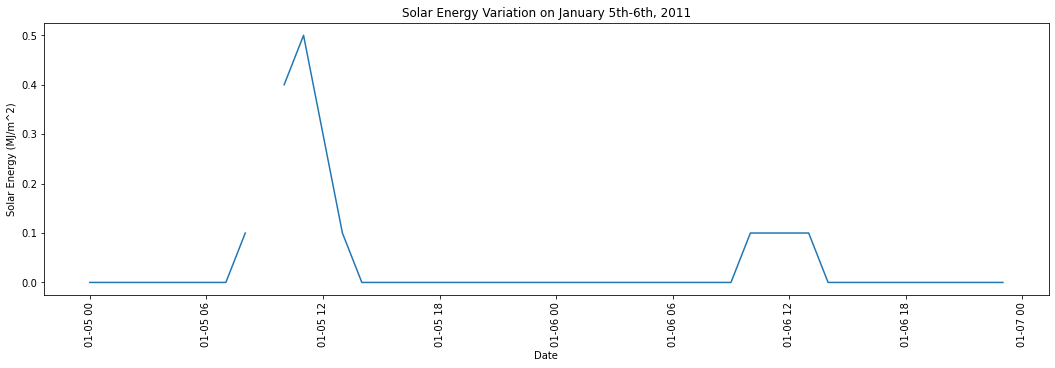

In [ ]:
# For solar energy
df_chunk = df.loc['2011-01-05':'2011-01-06']  # Since the date is an index, we can use it to filter our data

plt.figure(figsize=(18, 5))
plt.plot(df_chunk.index, df_chunk['solarenergy'])
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Solar Energy (MJ/m^2)')
plt.title('Solar Energy Variation on January 5th-6th, 2011')


plt.show()


In [ ]:
nulls = df['solarenergy'].isna()
df.loc[nulls, 'solarenergy'] = df['solarenergy'].shift(8760) #8760 periodos en un año


Como estoy llenando con el año anterior aun tengo nulls del 2010 que no tiene ningún año anterior pues es nuestro primer año

Vamos a llenar 2010 con el año 2011

In [ ]:
df[df['solarenergy'].isna()].head(5)

,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex
2010-01-24 03:00:00,3.8,2.5,91.33,0.0,0.0,NaN,0.0,0.0,9.7,345.0,1022.0,100.0,0.0,NaN,0.0
2010-02-05 23:00:00,6.8,5.7,92.55,0.0,0.0,NaN,0.0,0.0,12.4,124.0,1002.7,18.1,0.0,NaN,0.0
2010-03-10 05:00:00,2.4,-0.5,81.29,0.0,0.0,NaN,0.0,0.0,19.1,33.0,1028.2,100.0,0.0,NaN,0.0
2010-03-16 04:00:00,2.1,-0.9,80.92,0.0,0.0,NaN,0.0,0.0,5.5,322.0,1026.4,80.0,0.0,NaN,0.0
2010-03-28 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
nulls_2010 = df['solarenergy'].isna() & (df.index.year == 2010)
df.loc[nulls_2010, 'solarenergy'] = df['solarenergy'].shift(-1)

In [ ]:
df[df['solarenergy'].isna()].head(5)

,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex
2011-08-12 01:00:00,16.9,15.5,91.46,0.0,0.0,NaN,0.0,0.0,9.9,257.0,1010.8,49.9,0.0,NaN,0.0


In [ ]:
#no sé porqué me sigue saliendo un null el 2011-08-12 01:00:00 repito el proceso
nulls = df['solarenergy'].isna()
df.loc[nulls, 'solarenergy'] = df['solarenergy'].shift(8760) #8760 periodos en un año


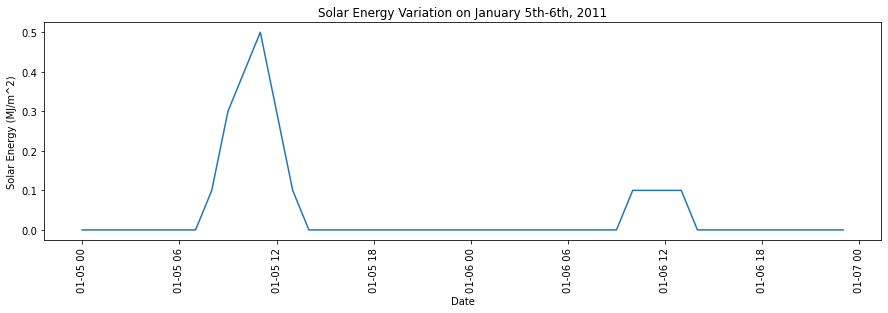

In [ ]:
# We observe that there are missing values

# Selecting the chunk of data for January 5th and 6th, 2011
df_chunk = df.loc['2011-01-05':'2011-01-06']

plt.figure(figsize=(15, 4))

plt.plot(df_chunk.index, df_chunk['solarenergy'])

# Rotating x-axis labels for better visibility
plt.xticks(rotation=90)

# Labeling x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Solar Energy (MJ/m^2)')

# Adding a title to the plot
plt.title('Solar Energy Variation on January 5th-6th, 2011')
plt.show()


Haremos lo mismo para los missing values de windspeed

In [ ]:
#display rows which have null values in "windspeed"
df[df['windspeed'].isna()].head()

,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex
2010-02-20 02:00:00,-0.4,-1.0,95.64,0.0,0.0,NaN,0.0,0.0,NaN,275.0,997.3,41.4,0.0,0.0,0.0
2010-03-13 02:00:00,4.7,3.5,91.53,0.0,0.0,NaN,0.0,0.0,NaN,9.0,1027.6,50.2,0.0,0.0,0.0
2010-03-16 03:00:00,1.9,-0.4,84.81,0.0,0.0,NaN,0.0,0.0,NaN,339.0,1026.5,10.0,0.0,0.0,0.0
2010-03-20 23:00:00,7.7,7.7,99.70,0.0,0.0,NaN,0.0,0.0,NaN,250.0,1005.6,74.0,0.0,0.0,0.0
2010-03-25 19:00:00,8.6,7.8,94.38,0.0,0.0,NaN,0.0,0.0,NaN,203.0,998.7,10.0,0.0,0.0,0.0


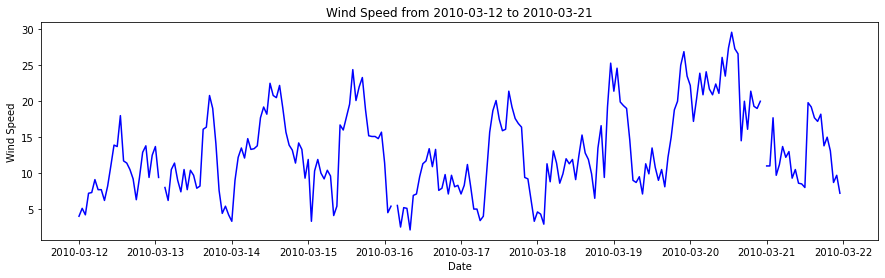

In [ ]:
# Select the chunk of data
df_chunk_wind = df.loc['2010-03-12':'2010-03-21']

# Plot the wind speed data
plt.figure(figsize=(15, 4))
plt.plot(df_chunk_wind.index, df_chunk_wind['windspeed'], color='blue', linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Wind Speed')
plt.title('Wind Speed from 2010-03-12 to 2010-03-21')

# Display the plot
plt.show()


In [ ]:
#Quitamos nulls de windspeed los llenamos con en año pasado
nulls = df['windspeed'].isna()
df.loc[nulls, 'windspeed'] = df['windspeed'].shift(8760) #8760 periodos en un año


In [ ]:
#también de 2010 que no tiene un año anterior para fill con este
nulls_2010 = df['windspeed'].isna() & (df.index.year == 2010)
df.loc[nulls_2010, 'windspeed'] = df['windspeed'].shift(-1)

In [ ]:
#Quitamos nulls de windspeed los llenamos con en año pasado
nulls = df['windspeed'].isna()
df.loc[nulls, 'windspeed'] = df['windspeed'].shift(8760) #8760 periodos en un año


In [ ]:
#Ya no tenemos null datos en windspeed ni en solarenergy
print(df.isna().sum())

temp                   268
dew                    290
humidity               283
precip                 293
precipprob             300
preciptype          111569
snow                 33044
snowdepth            33575
windspeed                0
winddir                291
sealevelpressure       539
cloudcover             302
solarradiation         344
solarenergy              0
uvindex                372
dtype: int64


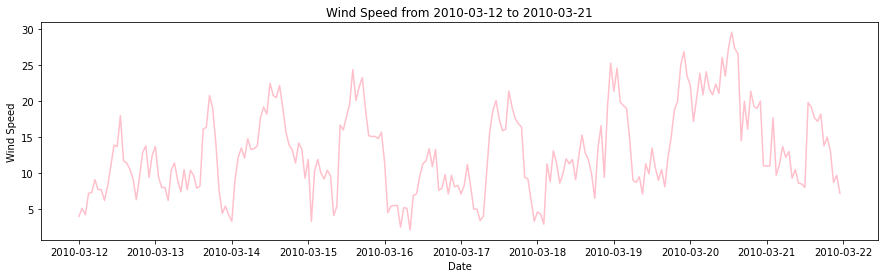

In [ ]:
# Select the chunk of data
df_chunk_wind = df.loc['2010-03-12':'2010-03-21']

# Plot the wind speed data
plt.figure(figsize=(15, 4))
plt.plot(df_chunk_wind.index, df_chunk_wind['windspeed'], color='pink', linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Wind Speed')
plt.title('Wind Speed from 2010-03-12 to 2010-03-21')

# Display the plot
plt.show()


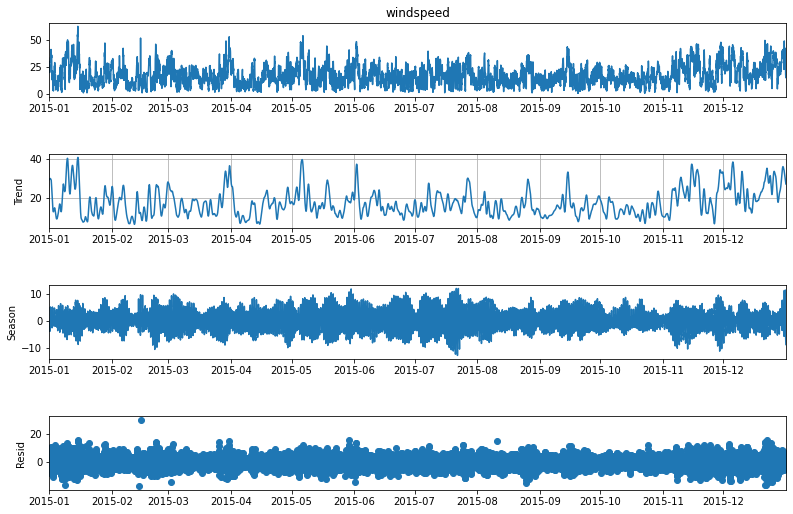

In [ ]:
# Try decomposition on the resampled dataset, using only the full years
# we can see only one year to see what is happening
decomposition = STL(df.loc['2015':'2015', 'windspeed']).fit()
fig = decomposition.plot()
fig.set_size_inches(12,8)
fig.axes[1].grid() # so we can check a bit better if there's a trend or not

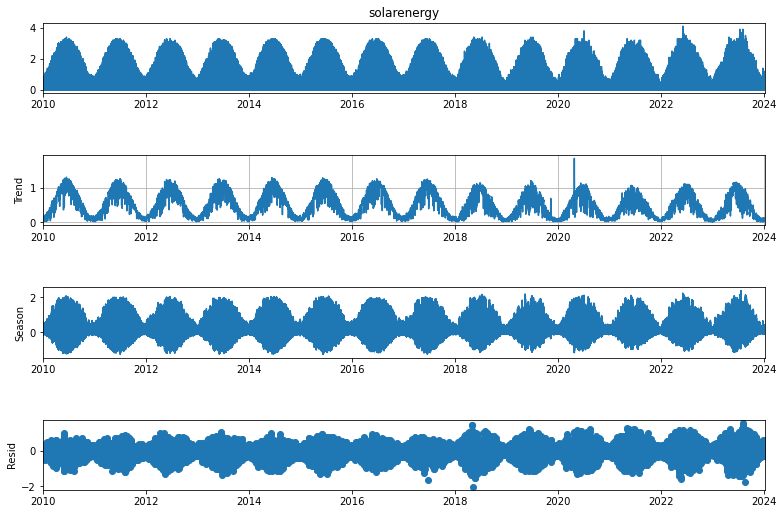

In [ ]:
# Try decomposition on the resampled dataset
decomposition = STL(df['solarenergy']).fit()
fig = decomposition.plot()
fig.set_size_inches(12,8)
fig.axes[1].grid() # so we can check a bit better if there's a trend or not
plt.savefig('..pdf', dpi=1000)

# EDA


Histograms for solar energy and wind speed


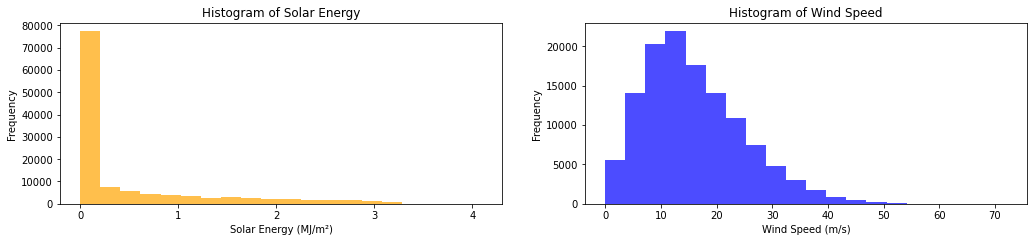

In [ ]:
# Create a figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))  # Increased the height to provide more space for labels

# Plot histogram for solar energy
axes[0].hist(df['solarenergy'], bins=20, color='orange', alpha=0.7)
axes[0].set_title('Histogram of Solar Energy')
axes[0].set_xlabel('Solar Energy (MJ/m²)')
axes[0].set_ylabel('Frequency')

# Plot histogram for wind speed
axes[1].hist(df['windspeed'], bins=20, color='blue', alpha=0.7)
axes[1].set_title('Histogram of Wind Speed')
axes[1].set_xlabel('Wind Speed (m/s)')
axes[1].set_ylabel('Frequency')

# Adjust layout and spacing between subplots
plt.tight_layout(pad=3.0)  # Increased the padding between subplots

# Show the plot
plt.show()


In [ ]:
# Crear columna de temporalidad
df['month'] = df.index.month
df['year'] = df.index.year
df['week_of_year'] = df.index.isocalendar().week
df['hour'] = df.index.hour


Let's see seasonal boxplots

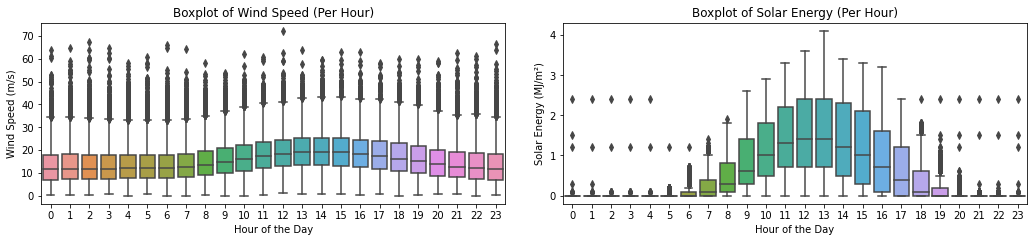

In [ ]:
# Create a figure and axes with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))  # Increased the height to accommodate titles and labels

# Boxplot for wind speed
sns.boxplot(x='hour', y='windspeed', data=df, ax=axes[0])
axes[0].set_title('Boxplot of Wind Speed (Per Hour)')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Wind Speed (m/s)')

# Boxplot for solar energy
sns.boxplot(x='hour', y='solarenergy', data=df, ax=axes[1])
axes[1].set_title('Boxplot of Solar Energy (Per Hour)')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Solar Energy (MJ/m²)')

# Adjust layout and spacing between subplots
plt.tight_layout(pad=3.0)  # Increased the padding between subplots

# Show the plot
plt.show()


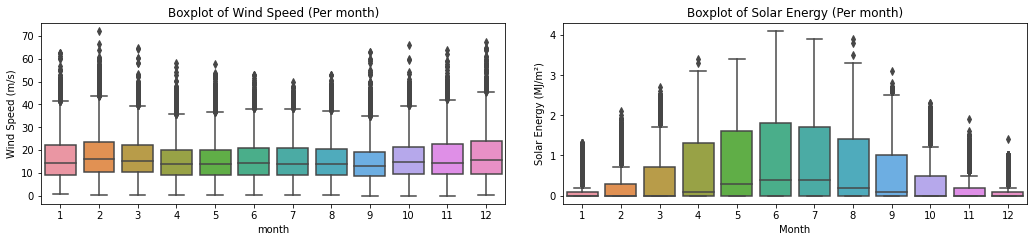

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))  # Increased the height to accommodate titles and labels

# Boxplot for wind speed
sns.boxplot(x='month', y='windspeed', data=df, ax=axes[0])
axes[0].set_title('Boxplot of Wind Speed (Per month)')
axes[0].set_xlabel('month')
axes[0].set_ylabel('Wind Speed (m/s)')

# Boxplot for solar energy
sns.boxplot(x='month', y='solarenergy', data=df, ax=axes[1])
axes[1].set_title('Boxplot of Solar Energy (Per month)')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Solar Energy (MJ/m²)')

# Adjust layout and spacing between subplots
plt.tight_layout(pad=3.0)  # Increased the padding between subplots

# Show the plot
plt.show()


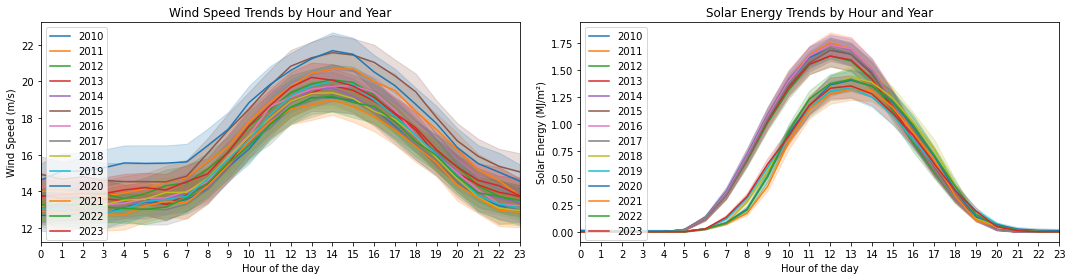

In [ ]:
# Filter the DataFrame to exclude data from 2024
df_filtered = df[df['year'] != 2024]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# Plot wind speed trends by hour and year
sns.lineplot(x='hour', y='windspeed', data=df_filtered, hue='year', palette='tab10', ax=axes[0])
axes[0].set_xticks(np.arange(0, 24))
axes[0].set_xlim(0, 23)
axes[0].set_xlabel('Hour of the day')
axes[0].set_ylabel('Wind Speed (m/s)')
axes[0].set_title('Wind Speed Trends by Hour and Year')
axes[0].legend(loc='upper left')  # Adjust the location of the legend

# Plot solar energy trends by hour and year
sns.lineplot(x='hour', y='solarenergy', data=df_filtered, hue='year', palette='tab10', ax=axes[1])
axes[1].set_xticks(np.arange(0, 24))
axes[1].set_xlim(0, 23)
axes[1].set_xlabel('Hour of the day')
axes[1].set_ylabel('Solar Energy (MJ/m²)')
axes[1].set_title('Solar Energy Trends by Hour and Year')
axes[1].legend(loc='upper left')  # Adjust the location of the legend

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


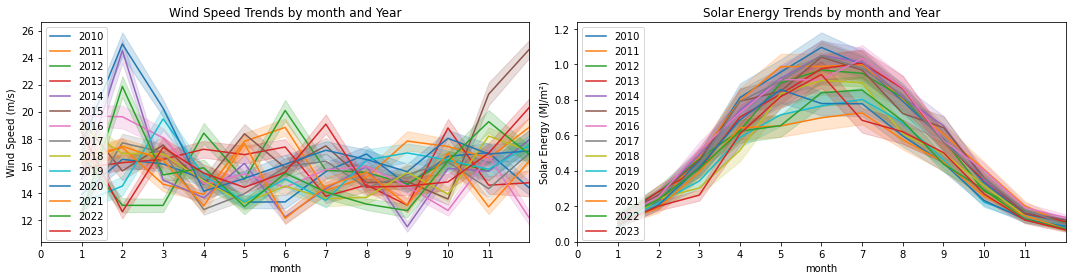

In [ ]:
# Filter the DataFrame to exclude data from 2024
df_filtered = df[df['year'] != 2024]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# Plot wind speed trends by hour and year
sns.lineplot(x='month', y='windspeed', data=df_filtered, hue='year', palette='tab10', ax=axes[0])
axes[0].set_xticks(np.arange(0, 12))
axes[0].set_xlim(0, 12)
axes[0].set_xlabel('month')
axes[0].set_ylabel('Wind Speed (m/s)')
axes[0].set_title('Wind Speed Trends by month and Year')
axes[0].legend(loc='upper left')  # Adjust the location of the legend

# Plot solar energy trends by hour and year
sns.lineplot(x='month', y='solarenergy', data=df_filtered, hue='year', palette='tab10', ax=axes[1])
axes[1].set_xticks(np.arange(0, 12))
axes[1].set_xlim(0, 12)
axes[1].set_xlabel('month')
axes[1].set_ylabel('Solar Energy (MJ/m²)')
axes[1].set_title('Solar Energy Trends by month and Year')
axes[1].legend(loc='upper left')  # Adjust the location of the legend

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


With these graphs, we can see that the wind varies a lot in different months, but we always have wind. Meanwhile, solar energy changes across different months. We could visualize this in a Heatmap.

The wind graph doesn't tell us much by year and month, but there's a clear trend in solar energy.

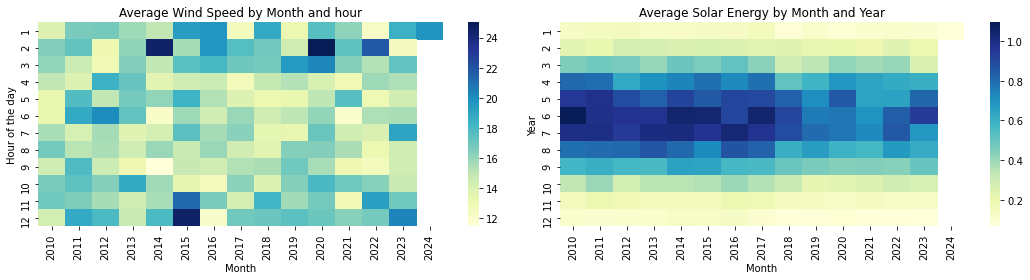

In [ ]:
# Pivot table for wind speed by month and hour
wind_pivot = df.pivot_table(index='month', columns='year', values='windspeed', aggfunc='mean')

# Pivot table for solar energy by month and hour
solar_pivot = df.pivot_table(index='month', columns='year', values='solarenergy', aggfunc='mean')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Wind speed heatmap
sns.heatmap(wind_pivot, cmap='YlGnBu', ax=axes[0])
axes[0].set_title('Average Wind Speed by Month and hour')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Hour of the day')

# Solar energy heatmap
sns.heatmap(solar_pivot, cmap='YlGnBu', ax=axes[1])
axes[1].set_title('Average Solar Energy by Month and Year')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Year')

plt.tight_layout()
plt.show()


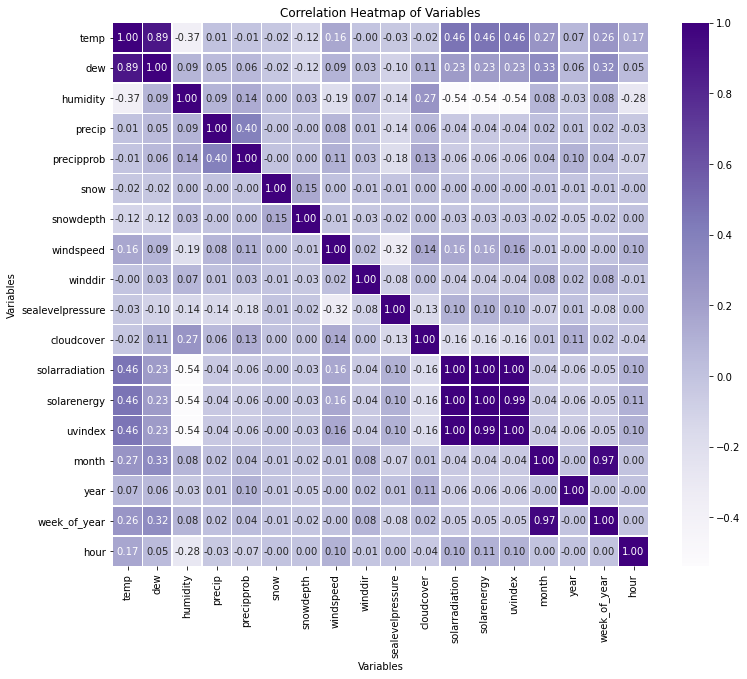

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Purples', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Variables')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()

Correlations give us insights into how variables relate to each other. However, if correlations are weak or nonexistent, it suggests there might not be a linear relationship between the variables.

It's important to note that correlations don't imply causation. They just show how variables move in relation to each other.

Next, we'll explore autocorrelation, which examines how a variable correlates with itself over time. This analysis could reveal interesting patterns and dependencies in our data, offering deeper insights into its dynamics.

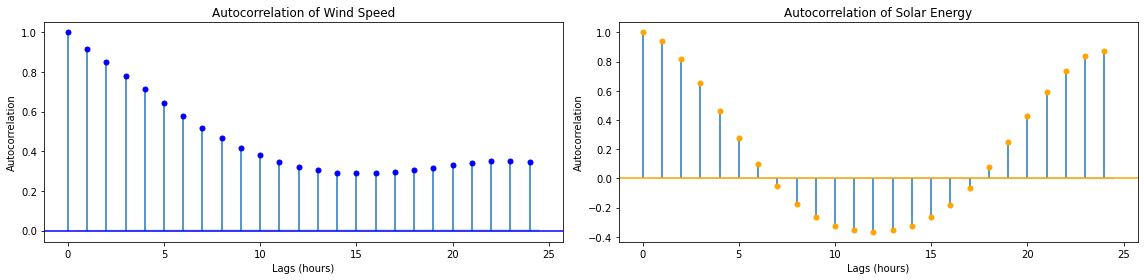

In [ ]:
# Autocorrelation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

# Autocorrelation for windspeed
plot_acf(df['windspeed'], lags=24, ax=axes[0], alpha=0.5, color='blue')
axes[0].set_title('Autocorrelation of Wind Speed')
axes[0].set_xlabel('Lags (hours)')
axes[0].set_ylabel('Autocorrelation')

# Autocorrelation for solarenergy
plot_acf(df['solarenergy'], lags=24, ax=axes[1], alpha=0.5, color='orange')
axes[1].set_title('Autocorrelation of Solar Energy')
axes[1].set_xlabel('Lags (hours)')
axes[1].set_ylabel('Autocorrelation')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()




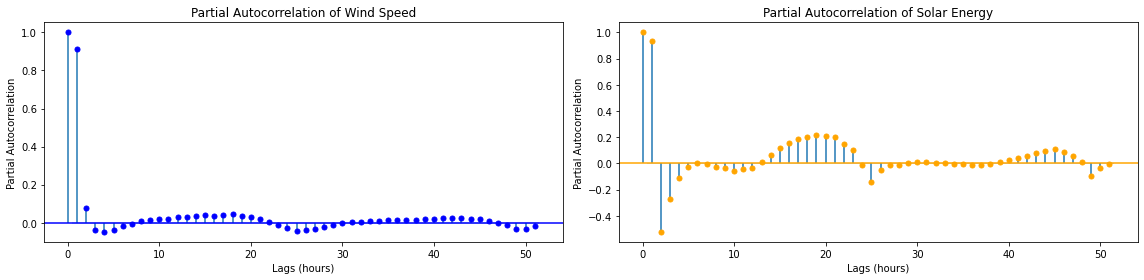

In [ ]:
# Partial autocorrelation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

# Partial autocorrelation for windspeed
plot_pacf(df['windspeed'], ax=axes[0], color='blue')
axes[0].set_title('Partial Autocorrelation of Wind Speed')
axes[0].set_xlabel('Lags (hours)')
axes[0].set_ylabel('Partial Autocorrelation')

# Partial autocorrelation for solarenergy
plot_pacf(df['solarenergy'], ax=axes[1], color='orange')
axes[1].set_title('Partial Autocorrelation of Solar Energy')
axes[1].set_xlabel('Lags (hours)')
axes[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()



# Assumptions

What we're interested in seeing is the energy generated by wind and solar power.

We can see on the page: https://www.idae.es/sites/default/files/documentos/publicaciones_idae/documentos_10374_energia_eolica_06_d9231f5c.pdf

The formula to calculate the power generated by a wind turbine is:

    P = 0.5 * ρ * S * V^3

Where:

- \( P \) = power in watts (W)
- \( ρ \) = air density in kg/m³
- \( S \) = swept area or rotor area in m²
- \( V \) = wind speed in m/s

The value of S, which represents the area swept by the rotor or the effective surface covered by the wind turbine blades, depends on the design and size of the wind turbine.

To calculate S, the formula for the area of a circle is typically used, as the rotor blades of the wind turbine can be considered as a moving circle. The formula for the area of a circle is:

    S = π * r^2

We will use π = 3.1416 for this calculation.

We will also use Hornsea Wind Farm as a reference for our variables.

The number of turbines in the Hornsea Wind Farm projects is as follows:

    Hornsea Project 1:
    174 turbines.
    Turbines: Siemens Gamesa SWT-7.0-154
    Rotor diameter: 154 meters
    Rotor radius: 77 meters

Air density = P/(R * T)

    P = atmospheric pressure in pascals (Pa).
    R = the gas constant for dry air.
    T = the air temperature in kelvin (K).

We estimate the typical household in England uses 2,700 kWh of electricity in a year. https://www.ofgem.gov.uk/information-consumers/energy-advice-households/average-gas-and-electricity-use-explained

    Consumo anual en Wh = Consumo anual en kWh * 1000
    365 días/año * 24 horas/día = 8,760 horas/año
    Consumo por hora = (Consumo anual en Wh) / (Número total de horas en un año)
    Consumo anual en Wh = 2,700 kWh * 1000 = 2,700,000 Wh
    Número total de horas en un año = 8,760 horas
    Consumo por hora a lo largo del año por casa = 2,700,000 Wh / 8,760 horas ≈ 308.22 Wh/hora
    según datos del censo de 2011, la ciudad de Brighton tenía alrededor de 156,000 poblacion, supongamos que en un ahogar viven 4 personas, entonces habrían 39,000 hogares, los cuales gastarían 39,000 * 308.22 = 12,010,980 Wh


It's possible that if people were to receive energy for free that day, their energy consumption might increase. When energy is perceived as abundant or free, people tend to use it with fewer restrictions or concerns about costs. This could lead to an increase in energy consumption by individuals who would normally be more mindful of their usage.

Let's assume they will consume three times more than what they normally consume.

In [ ]:
#Quitamos nulls de temp los llenamos con en año pasado
nulls = df['temp'].isna()
df.loc[nulls, 'temp'] = df['temp'].shift(8760) #8760 periodos en un año


In [ ]:
#Quitamos nulls de temp los llenamos con en año pasado
nulls = df['sealevelpressure'].isna()
df.loc[nulls, 'sealevelpressure'] = df['sealevelpressure'].shift(8760) #8760 periodos en un año


In [ ]:
# Constants
R = 287.05
radius_rotor = 77
area_rotor = np.pi * radius_rotor ** 2

# Convert data
df['temp_kelvin'] = df['temp'] + 273.15  # Celsius to Kelvin
df['windspeed_mps'] = df['windspeed'] / 3.6  # kph to m/s

# Calculates
df['air_density'] = df['sealevelpressure'] / (R * df['temp_kelvin'])
df['power_generated'] = 0.5 * df['air_density'] * area_rotor * (df['windspeed_mps'] ** 3) * 174  #174 turbinas
df.head(5)


,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,...,solarenergy,uvindex,month,year,week_of_year,hour,temp_kelvin,windspeed_mps,air_density,power_generated
2010-01-01 00:00:00,1.9,-0.5,84.25,0.417,100.0,"rain,snow",0.0,0.0,19.4,11.0,...,0.0,0.0,1,2010,53,0,275.05,5.388889,0.012664,3.211705e+06
2010-01-01 01:00:00,1.9,-0.5,83.90,0.000,0.0,NaN,0.0,0.0,21.8,19.0,...,0.0,0.0,1,2010,53,1,275.05,6.055556,0.012663,4.556763e+06
2010-01-01 02:00:00,1.4,-0.7,85.76,0.000,0.0,NaN,0.0,0.0,17.7,10.0,...,0.0,0.0,1,2010,53,2,274.55,4.916667,0.012689,2.443902e+06
2010-01-01 03:00:00,1.4,-0.7,85.69,0.000,0.0,NaN,0.0,0.0,18.0,11.0,...,0.0,0.0,1,2010,53,3,274.55,5.000000,0.012691,2.570801e+06
2010-01-01 04:00:00,1.3,-0.8,85.72,0.000,0.0,NaN,0.0,0.0,17.4,10.0,...,0.0,0.0,1,2010,53,4,274.45,4.833333,0.012700,2.323738e+06


Ahora, para la energía solar:

To convert energy from MJ/m² to Wh per hour, first, we need to consider that 1 MJ (megajoule) equals 1,000,000 joules and 1 Wh (watt-hour) equals 3,600 joules. Here is the formula for the conversion:

    Energy in Wh per hour = Solar energy in MJ/m^2 * Area of the solar panels * 1000000 * 3.6


https://www.damiasolar.com/actualidad/blog/articulos-sobre-la-energia-solar-y-sus-componentes/cuanta-electricidad-genera-un-panel-solar-y-como-calcularla-

In [ ]:
area_paneles = 10  # m^2

df['energia_total'] = df['solarenergy'] * area_paneles * 1000000 * 3.6


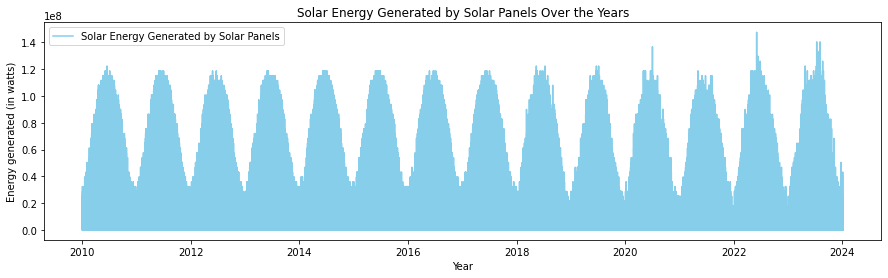

In [ ]:
# Let's plot the data.
plt.figure(figsize=(15,4))
plt.plot(df.index, df['energia_total'], color ='#87CEEB', label='Solar Energy Generated by Solar Panels')
plt.xlabel('Year')
plt.ylabel('Energy generated (in watts)')
plt.title('Solar Energy Generated by Solar Panels Over the Years')
plt.legend()
plt.show()

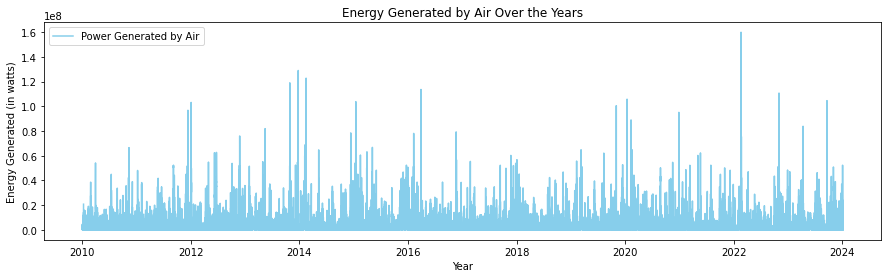

In [ ]:
# Let's plot the data.
plt.figure(figsize=(15,4))
plt.plot(df.index, df['power_generated'], label='Power Generated by Air', color = '#87CEEB')
plt.xlabel('Year')
plt.ylabel('Energy Generated (in watts)')
plt.title('Energy Generated by Air Over the Years')
plt.legend()
plt.show()

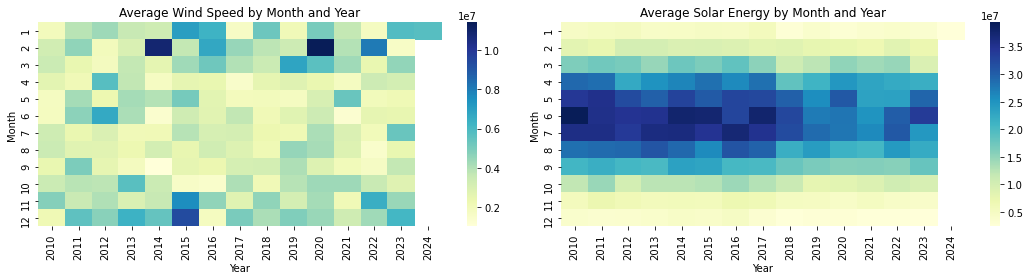

In [ ]:
# Pivot table for wind speed by month and hour
wind_pivot = df.pivot_table(index='month', columns='year', values='power_generated', aggfunc='mean')

# Pivot table for solar energy by month and hour
solar_pivot = df.pivot_table(index='month', columns='year', values='energia_total', aggfunc='mean')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Wind speed heatmap
sns.heatmap(wind_pivot, cmap='YlGnBu', ax=axes[0])
axes[0].set_title('Average Wind Speed by Month and Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Month')

# Solar energy heatmap
sns.heatmap(solar_pivot, cmap='YlGnBu', ax=axes[1])
axes[1].set_title('Average Solar Energy by Month and Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Month')

plt.tight_layout()
plt.show()


We could consider the energy generated by the sun and the wind to make our future forecasts.

This is just an idea we can consider later

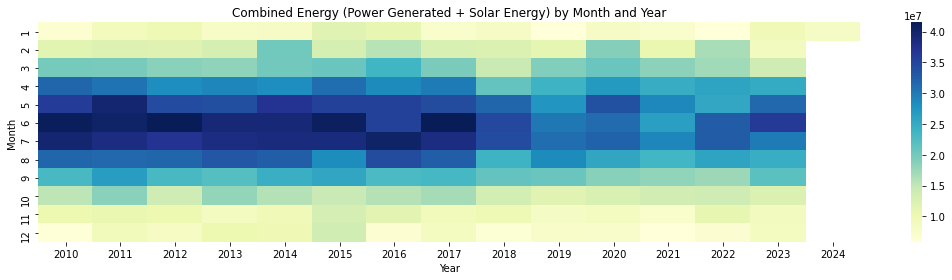

In [ ]:
# Combine power_generated and energia_total into a single variable
df['combined_energy'] = df['power_generated'] + df['energia_total']

# Pivot table for combined energy by month and year
combined_energy_pivot = df.pivot_table(index='month', columns='year', values='combined_energy', aggfunc='mean')

# Create the heatmap plot
plt.figure(figsize=(15, 4))
sns.heatmap(combined_energy_pivot, cmap='YlGnBu')

# Set the title and labels
plt.title('Combined Energy (Power Generated + Solar Energy) by Month and Year')
plt.xlabel('Year')
plt.ylabel('Month')

plt.tight_layout()
plt.show()
